# Example: Cargo Flows

This example replicates SignalOcean's "Cargo Flows" dashboard, which visualizes the flow of cargo of either imports/exports from a specific load area and of a specific vessel class. This example requires a combination of voyage and vessel data to extract an estimate of the cargo (deadweight). 

In order to import the vessel data, this example will showcase both direct VesselsAPI calls to get vessels by class, as well as demonstrate importing from a persisted database. 



## Setup

Install the Signal Ocean SDK:

In [ ]:
pip install signal-ocean

Import required libraries / APIs / packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

from signal_ocean.voyages import VoyagesAPI
from signal_ocean.vessels import VesselsAPI
from signal_ocean import VesselClassAPI, VesselClassFilter, Connection
from datetime import datetime, date, timedelta, timezone

Fill in your personal SignalOcean API subscription key acquired <a href="https://apis.signalocean.com/profile" target="_blank">here</a> and open a connection:

In [2]:
signal_ocean_api_key = '' #replace with your subscription key
connection = Connection(signal_ocean_api_key)

## 1. Importing the Vessel data

This notebook will demonstrate two different ways to import vessel data for the purpose of utillising them in a cargo flows example:

> **1.1.** Get vessels by vessel class.<br>
> **1.2.** Persist and get vessels from a persisted database (.db file).

Note: Persisting the vessel data, as shown in *section 1.2*, is considered good-practise while working with the SDK.

First of all, we need to instantiate the required vessel APIs:

In [3]:
vessels_api = VesselsAPI(connection)
vessel_class_api = VesselClassAPI(connection)

### 1.1. Get vessel data by vessel class

Display all vessel classes,

In [4]:
pd.DataFrame(vessel_class_api.get_vessel_classes()).set_index('id').sort_values('id')

,name
id,
60,VLGCLpg
61,MidsizeLpg
62,HandyLpg
63,SmallLpg
69,VLOC
70,Capesize
72,PostPanamaxDry
74,PanamaxDry
75,Supramax


Specify the vessel class ID of interest,

In [5]:
vessel_class_id = 70

Get vessels filtered only by the specified vessel class,

In [6]:
vessels = vessels_api.get_vessels_by_vessel_class(vesselClass=vessel_class_id, point_in_time=date.today())
vessels = pd.DataFrame(v.__dict__ for v in vessels)
vessels

,imo,vessel_type_id,built_for_trade_id,trade_id,vessel_class_id,commercial_operator_id,deadweight,breadth_extreme,gross_rated_tonnage,reduced_gross_tonnage,...,cubic_size,scrubbers_date,summer_tpc,lightship_tonnes,main_engine_manufacturer,delivery_date,classification_register,number_of_holds,grain_capacity,bale_capacity
0,7001027,3,-2,-1,70,-1,162813,43,88826,76007,...,None,NaT,NaN,21710,NotSet,1969-07-01 00:00:00+00:00,Not set,NaN,172111.0,NaN
1,7027435,3,-2,-1,70,-1,140440,43,70872,76007,...,None,NaT,NaN,18726,NotSet,1970-07-01 00:00:00+00:00,Not set,NaN,144903.0,NaN
2,7329584,3,-2,-1,70,-1,129537,41,67614,76007,...,None,NaT,NaN,17273,NotSet,1973-07-01 00:00:00+00:00,Not set,NaN,141174.0,NaN
3,7361075,3,-2,-1,70,-1,122970,39,64548,76007,...,None,NaT,NaN,16397,NotSet,1975-07-01 00:00:00+00:00,Not set,NaN,138450.0,NaN
4,7361087,3,-2,-1,70,-1,122933,39,64552,76007,...,None,NaT,NaN,16392,NotSet,1975-07-01 00:00:00+00:00,Not set,NaN,138623.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,9902677,3,-1,-1,70,-1,210000,46,109261,76049,...,None,NaT,138.200,28002,Wartsila,2021-07-01 00:00:00+00:00,Not set,9.0,218000.0,NaN
2041,9902689,3,-2,-1,70,-1,210000,50,109665,76049,...,None,NaT,140.096,28002,NotSet,2021-07-01 00:00:00+00:00,Not set,9.0,224800.0,NaN
2042,9906013,3,-1,-1,70,-1,210000,46,109534,76049,...,None,NaT,137.900,28002,MAN B&W,2021-02-02 00:00:00+00:00,Not set,9.0,224717.0,NaN
2043,9906025,3,-1,-1,70,-1,210000,46,109534,76049,...,None,NaT,137.900,28002,MAN B&W,2021-04-07 00:00:00+00:00,Not set,9.0,224717.0,NaN


### 1.2. Get vessel data from a persisted local database

This section demonstrates how to read data from a persisted database, by also showing how to persist the data in the first place. For brevity and to satisfy the needs of the example, the imported vessel data from section 1.1 will be used.

In [7]:
import os
import sqlite3
from sqlalchemy import create_engine

#### Persist data

Creating an SQLite database (overwrites):

In [8]:
db_name = 'vessels.db'
db_conn = sqlite3.connect(db_name)

Create table and persist imported vessel data,

In [9]:
engine = create_engine(f'sqlite:///{os.path.join(os.path.abspath(os.getcwd()), db_name)}')
vessels.to_sql('Vessels', engine, index=True, if_exists="replace")
db_conn.close()

#### Import data

In [10]:
db_conn = sqlite3.connect(db_name)

query = db_conn.execute('SELECT * FROM Vessels')
vessels = pd.DataFrame.from_records(data=query.fetchall(), 
                                    columns=[column[0] for column in query.description]).drop(labels='index', axis=1)

db_conn.close()
vessels

,imo,vessel_type_id,built_for_trade_id,trade_id,vessel_class_id,commercial_operator_id,deadweight,breadth_extreme,gross_rated_tonnage,reduced_gross_tonnage,...,cubic_size,scrubbers_date,summer_tpc,lightship_tonnes,main_engine_manufacturer,delivery_date,classification_register,number_of_holds,grain_capacity,bale_capacity
0,7001027,3,-2,-1,70,-1,162813,43,88826,76007,...,None,None,NaN,21710,NotSet,1969-07-01 00:00:00.000000,Not set,NaN,172111.0,NaN
1,7027435,3,-2,-1,70,-1,140440,43,70872,76007,...,None,None,NaN,18726,NotSet,1970-07-01 00:00:00.000000,Not set,NaN,144903.0,NaN
2,7329584,3,-2,-1,70,-1,129537,41,67614,76007,...,None,None,NaN,17273,NotSet,1973-07-01 00:00:00.000000,Not set,NaN,141174.0,NaN
3,7361075,3,-2,-1,70,-1,122970,39,64548,76007,...,None,None,NaN,16397,NotSet,1975-07-01 00:00:00.000000,Not set,NaN,138450.0,NaN
4,7361087,3,-2,-1,70,-1,122933,39,64552,76007,...,None,None,NaN,16392,NotSet,1975-07-01 00:00:00.000000,Not set,NaN,138623.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,9902677,3,-1,-1,70,-1,210000,46,109261,76049,...,None,None,138.200,28002,Wartsila,2021-07-01 00:00:00.000000,Not set,9.0,218000.0,NaN
2041,9902689,3,-2,-1,70,-1,210000,50,109665,76049,...,None,None,140.096,28002,NotSet,2021-07-01 00:00:00.000000,Not set,9.0,224800.0,NaN
2042,9906013,3,-1,-1,70,-1,210000,46,109534,76049,...,None,None,137.900,28002,MAN B&W,2021-02-02 00:00:00.000000,Not set,9.0,224717.0,NaN
2043,9906025,3,-1,-1,70,-1,210000,46,109534,76049,...,None,None,137.900,28002,MAN B&W,2021-04-07 00:00:00.000000,Not set,9.0,224717.0,NaN


### 2. Importing Voyages data 

This section demonstrates how to make a call to the VoyagesAPI and extract voyage data under certain specified filters. The vessel class workflow (from *section 1*) will be used for the purposes of the example. 

In [11]:
voyages_api = VoyagesAPI(connection)

Specify call parameters:

In [12]:
area_of_interest = 'Australia West'
date_from = date(2018,12,31)         # refers to first_load_arrival_date_from
activity = 'export'                  # either "import" or "export"

Extract voyages and their events filtered by vessel class,

In [13]:
voyages = voyages_api.get_voyages_by_advanced_search(vessel_class_id=vessel_class_id, first_load_arrival_date_from=date_from)
voyages = pd.DataFrame(v.__dict__ for v in voyages)

events = pd.DataFrame(e.__dict__ for voyage_events in voyages['events'].dropna() for e in voyage_events)

Expose necessary cargo flow events:

In [14]:
def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_load_country(voyage_events):
    return next((e.country for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_country(voyage_events):
    return next((e.country for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

voyages['load_area'] = voyages['events'].apply(get_voyage_load_area)
voyages['load_country'] = voyages['events'].apply(get_voyage_load_country)
voyages['discharge_country'] = voyages['events'].apply(get_voyage_discharge_country)

Filter voyages by either "imports" or "exports":

In [15]:
def get_voyages_by_activity(voyages, activity):
    if activity == 'export':
        return voyages[(voyages['load_area']==area_of_interest)&(voyages['discharge_country']!=area_of_interest)]
    elif activity == 'import':
        return voyages[(voyages['discharge_country']==area_of_interest)&(voyages['load_area']!=area_of_interest)]
    else:
        raise ValueError('Activity parameter must take values "import" or "export".')
        
voyages_by_activity = get_voyages_by_activity(voyages, activity)

Filter out the predicted voyages and visualize the dataframe:

In [16]:
voyages_by_activity = voyages_by_activity[pd.to_datetime(voyages_by_activity['first_load_arrival_date']) <= datetime.now(tz=timezone.utc)].reset_index(drop=True)
voyages_by_activity

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,vessel_name,...,fixture_date,fixture_is_coa,fixture_is_hold,is_implied_by_ais,has_manual_entries,ballast_distance,laden_distance,load_area,load_country,discharge_country
0,9165322,68,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED41A3F00', port_id=8...",I8BDA0AVED41A3F00,Great Sunrise,...,NaT,None,None,None,None,3568.06,3721.32,Australia West,Australia,Japan
1,9165322,69,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED4695900', port_id=8...",I8BDA0AVED4695900,Great Sunrise,...,NaT,None,None,None,None,3559.00,3699.87,Australia West,Australia,Japan
2,9165322,70,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED4B87300', port_id=8...",I8BDA0AVED4B87300,Great Sunrise,...,NaT,None,None,None,None,3567.84,3639.62,Australia West,Australia,Japan
3,9165322,74,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED6930F00', port_id=8...",I8BDA0AVED6930F00,Great Sunrise,...,NaT,None,None,None,None,3537.96,3562.22,Australia West,Australia,Japan
4,9165322,75,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED6E22900', port_id=8...",I8BDA0AVED6E22900,Great Sunrise,...,NaT,None,None,None,None,3565.06,3601.37,Australia West,Australia,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9930,9902689,1,3,70,1,-1,False,"(VoyageEvent(id='I971A61SED8461E00', port_id=3...",I971A61VED8461E00,Hui Xiu Hai,...,2021-07-02 07:56:46+00:00,False,False,True,None,4566.63,NaN,Australia West,Australia,China
9931,9906013,2,3,70,1,-1,False,"(VoyageEvent(id='I97275DSED81E9100', port_id=6...",I97275DVED81E9100,Trust Qingdao,...,NaT,None,None,None,None,3754.81,3506.24,Australia West,Australia,China
9932,9906013,3,3,70,1,-1,False,"(VoyageEvent(id='I97275DSED8461E00', port_id=3...",I97275DVED8461E00,Trust Qingdao,...,2021-07-16 02:34:29+00:00,False,False,None,None,3378.24,1102.59,Australia West,Australia,China
9933,9906025,1,3,70,1,-1,False,"(VoyageEvent(id='I972769SED7CF7700', port_id=3...",I972769VED7CF7700,H1519,...,NaT,None,None,None,None,3833.06,3618.56,Australia West,Australia,China


Merge voyage and vessel dataframes using vessel IMO as key and keep only useful information,

In [17]:
voyages_with_vessels_data = voyages_by_activity.merge(vessels, on='imo')
voyages_with_vessels_data = voyages_with_vessels_data[['first_load_arrival_date','deadweight','load_area','load_country','discharge_country']].sort_values('first_load_arrival_date').reset_index(drop=True)
voyages_with_vessels_data

,first_load_arrival_date,deadweight,load_area,load_country,discharge_country
0,2018-12-31 03:55:12+00:00,180377,Australia West,Australia,China
1,2018-12-31 03:56:54+00:00,175931,Australia West,Australia,China
2,2018-12-31 03:59:02+00:00,207392,Australia West,Australia,China
3,2018-12-31 07:52:47+00:00,179178,Australia West,Australia,China
4,2018-12-31 11:58:07+00:00,203280,Australia West,Australia,China
...,...,...,...,...,...
9930,2021-07-21 12:44:57.488000+00:00,206190,Australia West,Australia,China
9931,2021-07-21 13:02:42+00:00,171926,Australia West,Australia,China
9932,2021-07-21 13:05:39.150000+00:00,178043,Australia West,Australia,China
9933,2021-07-21 13:33:50+00:00,209000,Australia West,Australia,China


## 3. Plotting the data

### 3.1. Plot: Volume per Week

The volume per week plot is very useful in getting a high-level overview of cargo flows for the provided filters.<br>
In order to plot it, we need to create bins of weeks-of-interest, which start from a Monday, end on a Sunday and are time-beggining. The bins can be changed to any supported frequency by modifying the *freq* parameter.

In the following dataframe, we create the grouping bins by date:

In [18]:
dates = pd.date_range(start=date_from, end=date.today(), freq='W-MON', tz='UTC') 
weeks_from_monday = pd.DataFrame(dates, columns=['first_load_arrival_date'])

Group voyages deadweight into weekly bins (starting from Monday) and take the sum,

In [19]:
volume_per_week = voyages_with_vessels_data[['first_load_arrival_date', 'deadweight']].groupby(pd.Grouper(key='first_load_arrival_date', freq='W-MON', closed='right')).sum().reset_index()
volume_per_week

,first_load_arrival_date,deadweight
0,2018-12-31 00:00:00+00:00,2045253
1,2019-01-07 00:00:00+00:00,11497005
2,2019-01-14 00:00:00+00:00,11147890
3,2019-01-21 00:00:00+00:00,14712413
4,2019-01-28 00:00:00+00:00,11729516
...,...,...
130,2021-06-28 00:00:00+00:00,15432892
131,2021-07-05 00:00:00+00:00,13305789
132,2021-07-12 00:00:00+00:00,13896200
133,2021-07-19 00:00:00+00:00,12598327


Filter the grouped output using the weeks-of-interest bins that were generated at the start of this section.

In [20]:
volume_per_week = weeks_from_monday.merge(volume_per_week, how='left', on='first_load_arrival_date')
volume_per_week['deadweight'] /= 1e6 # in million tonnes
volume_per_week

,first_load_arrival_date,deadweight
0,2018-12-31 00:00:00+00:00,2.045253
1,2019-01-07 00:00:00+00:00,11.497005
2,2019-01-14 00:00:00+00:00,11.147890
3,2019-01-21 00:00:00+00:00,14.712413
4,2019-01-28 00:00:00+00:00,11.729516
...,...,...
129,2021-06-21 00:00:00+00:00,14.342634
130,2021-06-28 00:00:00+00:00,15.432892
131,2021-07-05 00:00:00+00:00,13.305789
132,2021-07-12 00:00:00+00:00,13.896200


Plot the volume per week chart as follows:

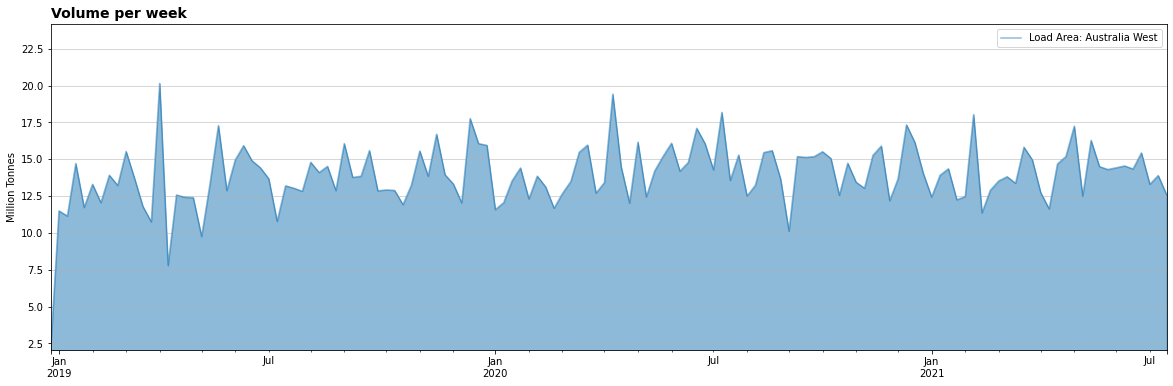

In [21]:
fig, axs = plt.subplots(figsize=(20,6))
volume_per_week.plot(ax=axs, x='first_load_arrival_date', y='deadweight', kind ='area', stacked=False)

# Properties
axs.set_xlabel('')
axs.set_ylabel('Million Tonnes')
axs.set_title('Volume per week',  fontsize=14, fontweight='bold', loc='left',)
axs.legend([f'Load Area: {area_of_interest}'])
axs.set_ylim([min(volume_per_week['deadweight']), 1.2*max(volume_per_week['deadweight'])]);
axs.grid(which='major', axis='y', linewidth=0.5)

### 3.2. Plot: Countries of Destination

The countries of destination plot gives insight to which country the cargo from the specified load area ends up in and in what amount. <br>
To plot it, we need to re-filter the voyages dataframe by date in order to get the date-range of interest. Also, we need to group voyages by discharge country and calculate the percentage of deadweight being imported/exported compared to all the other countries.

First off, specify a new starting date:

In [22]:
date_from = date(2021,1,1) 

Group voyages by countries of destination,

In [23]:
voyages_countries_of_destination = voyages_with_vessels_data.loc[voyages_with_vessels_data['first_load_arrival_date'].dt.date >= date_from].reset_index(drop=True)
voyages_countries_of_destination = voyages_countries_of_destination.groupby(by='discharge_country').sum().reset_index().sort_values('deadweight', ascending=True).reset_index(drop=True)

Compute voyage percentages performing specified activity at each country and append,

In [24]:
voyages_countries_of_destination['%_deadweight'] = 100*voyages_countries_of_destination['deadweight'] / voyages_countries_of_destination['deadweight'].sum()
voyages_countries_of_destination

,discharge_country,deadweight,%_deadweight
0,Netherlands,180000,0.044530
1,Singapore,207990,0.051454
2,Malaysia,743741,0.183991
3,Australia,2121522,0.524835
4,Indonesia,2438408,0.603228
5,Viet Nam,6316932,1.562721
6,Taiwan,12707817,3.143738
7,"Korea, Republic of",23662879,5.853869
8,Japan,31194003,7.716964
9,China,324653054,80.314670


Plot the countries of destination chart as follows:

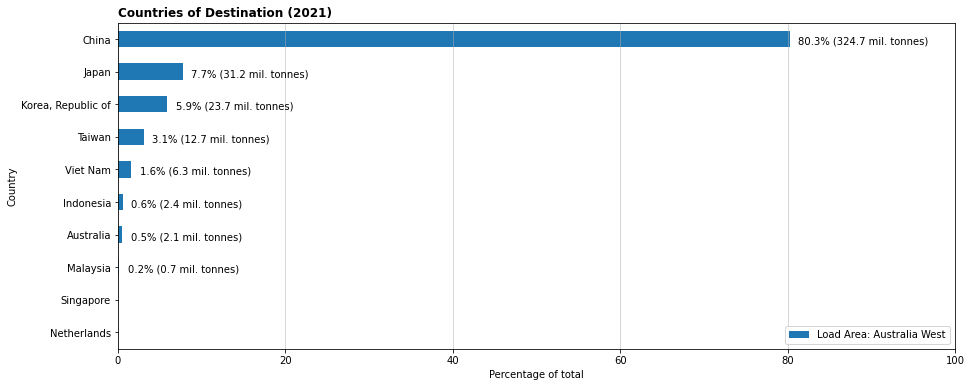

In [25]:
fig, axs = plt.subplots(figsize=(15,6))
voyages_countries_of_destination.plot.barh(ax=axs, y='%_deadweight', x='discharge_country')

# Properties
axs.set_title(f'Countries of Destination ({date_from.year})', loc='left', fontweight='bold')
axs.set_ylabel('Country')
axs.set_xlabel('Percentage of total')
axs.get_legend().remove()
axs.legend([f'Load Area: {area_of_interest}'], loc='lower right')

axs.set_xlim([0, 100])
axs.grid(which='major', axis='x', linewidth=0.5)

for i, v in enumerate(round(voyages_countries_of_destination['%_deadweight'],1)): # attach annotations at end of bars
    if voyages_countries_of_destination['%_deadweight'][i] >= 0.1:
        dwt = voyages_countries_of_destination['deadweight'][i]
        axs.text(v + 1, i - 0.15, f'{v}% ({round(dwt/1e6,1)} mil. tonnes)', color='black')

### 3.3. Plot: Volume Per Month 

The volume per month plot is useful in visualizing how the volume of cargo being transported from/to the specified area changes from year to year on a monthly level.

First, specify how many years back, from the current year, we want to compare and aggregate the voyages deadweight into the respective date-range bins:

In [26]:
years_back = 3

Calculate volume per month,

In [27]:
# Create a new dataframe and aggregate cargo by month and year (multiIndex)
vpm = voyages_with_vessels_data[['first_load_arrival_date', 'deadweight']].set_index('first_load_arrival_date')
volume_per_month = vpm.groupby([vpm.index.month, vpm.index.year]).sum()
volume_per_month.index.rename(['month','year'], inplace=True)

# Filter to last "years_back" years
years = volume_per_month.index.get_level_values('year')
volume_per_month = volume_per_month[years > (date.today().year - years_back)]

volume_per_month['deadweight'] /= 1e6 # in million tonnes
volume_per_month

deadweight
month year            
1     2019   54.537220
      2020   57.249031
      2021   55.943235
2     2019   52.797782
      2020   52.523605
      2021   57.327632
3     2019   64.467135
      2020   63.861629
      2021   63.757555
4     2019   47.993864
      2020   64.988036
      2021   61.424780
5     2019   61.488027
      2020   63.948967
      2021   63.512448
6     2019   63.809203
      2020   66.090437
      2021   62.976756
7     2019   55.929917
      2020   66.453825
      2021   39.283940
8     2019   63.300021
      2020   63.223104
9     2019   59.815629
      2020   60.351136
10    2019   58.553987
      2020   62.025956
11    2019   62.853948
      2020   60.920030
12    2019   66.694795
      2020   67.546457

We can now plot the volume per month chart as follows:

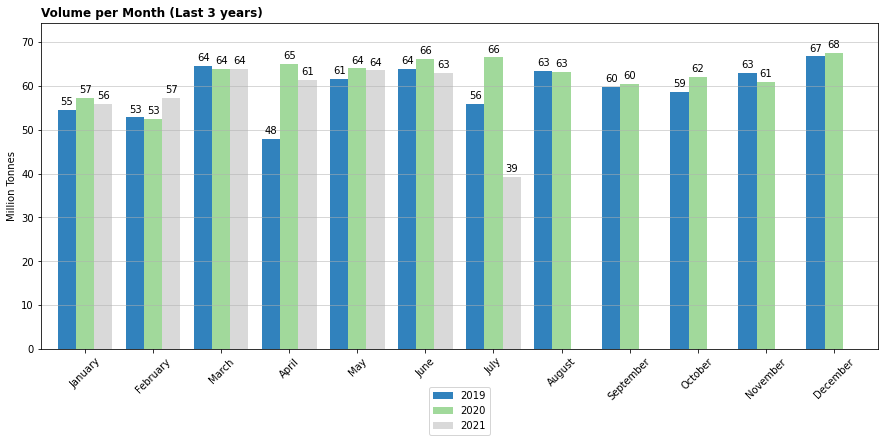

In [28]:
fig, axs = plt.subplots(figsize=(15,6))
volume_per_month.unstack().plot(kind='bar', ax=axs, width=0.8, colormap='tab20c')

# Properties
axs.set_title(f'Volume per Month (Last {years_back} years)', loc='left', fontweight='bold')
axs.set_ylabel('Million Tonnes')
axs.set_xlabel('')
axs.legend(years.unique(), loc='upper center', bbox_to_anchor=(0.5, -0.1))
axs.set_ylim([0, 1.1*max(volume_per_month['deadweight'])])

months = list(map(str, volume_per_month.index.get_level_values('month').array.unique()))
months = [datetime.strftime(datetime.strptime(m, '%m'), '%B') for m in months]
axs.set_xticklabels(months, rotation=45)

axs.grid(which='major', axis='y', linewidth=0.5)

for bar in axs.patches:
    if bar.get_height() > 0:
        axs.annotate(format(bar.get_height(), '0.0f'),
                    (bar.get_x() + bar.get_width()/2,
                     bar.get_height()), ha='center', va='center',
                     size=10, xytext=(0, 8),
                     textcoords='offset points')